# Candidate Test 2022 Analysis Part 1

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2).

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:
- Age of the candidates grouped by parties.
- An overview of the most "confident" candidates, i.e., those with the highest proportion of "strongly agree" or "strongly disagree" responses.
- Differences in responses between candidates, both inter-party and intra-party, along with an explanation of which parties have the most internal disagreements.
- Classification models to predict candidates' party affiliations. Investigate if there are any candidates who seem to be in the "wrong" party based on their political landscape positions. You must use the following three algorithms: **Decision Tree, Random Forrest, and Gradient Boosted Tree**, and **two other** classification algorithms of your choice, i.e. a total of 5 models are to be trained.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



In [110]:
# pip install pandas
# pip install scikit-learn
# pip install wordcloud
import pandas as pd
import sklearn as sk

# load the data
responsesFromBothDRTV2 = pd.read_excel('alldata.xlsx')
responsesFromBothDRTV2.rename(columns={'alder': 'Age', 'storkreds': 'District', 'navn': 'Name', 'parti': 'Party'}, inplace=True)
responsesFromDR=pd.read_excel('drdata.xlsx')
responsesFromDR.rename(columns={'navn': 'Name', 'parti': 'Party' }, inplace=True)
questionsFromDR=pd.read_excel('drq.xlsx')
questionsFromDR.rename(columns={'ID': 'id', }, inplace=True)
questionsFromTV2=pd.read_excel('tv2q.xlsx')
questionsFromTV2.rename(columns={'question': 'Question', 'header': 'Title'}, inplace=True)
responsesFromTV2=pd.read_excel('tv2data.xlsx')
responsesFromTV2.rename(columns={'navn': 'Name', 'parti': 'Party', 'alder': 'Age', 'storkreds': 'District'}, inplace=True)
electedData=pd.read_excel('electeddata.xlsx')
electedData.rename(columns={'navn': 'Name', 'parti': 'Party', 'alder': 'Age', 'storkreds': 'District'}, inplace=True)

# Define DR and TV2 question columns based on the given IDs
dr_questions = ['530', '531', '533', '534', '535', '537', '538', '540', '541', '543', '544', 
                '545', '546', '547', '548', '550', '551', '552', '553', '555', '556', '557', 
                '559', '561', '563']  # DR question columns
tv2_questions = ['1a', '1b', '2a', '2b', '3a', '3b', '4a', '4b', '5a', '5b', '6a', '6b', 
                 '7a', '7b', '8a', '8b', '9a', '9b', '10a', '10b', '11a', '11b', '12a', '12b']

#Creating DR dataframe with questions+Responses
"""Note: Missing ages and districts for candidates
Only place to look for arguments for and against"""
responses_melted = responsesFromDR.melt(
    id_vars=['Name', 'Party'],  # Use Name and Party (adjust if needed)
    value_vars=dr_questions,  # Use only existing question ID columns
    var_name='id',
    value_name='response'
)
responses_melted['id'] = responses_melted['id'].astype(int)

merged_DRdata = pd.merge(
    responses_melted, 
    questionsFromDR, 
    left_on='id',  # Column in the melted DataFrame
    right_on='id',  # Column in the questions DataFrame
    how='left'  # Use a left join to keep all responses
)
# Remove the 'Wordmerge'(only contains 1 value:(0) and 'Info'(only contains 1 value: NAn) columns & 'Rule'(only contains 1 value: 'FT')
#'ID_CandidateQuestionType (only contained 1 value) & QuestionListData (only contains Nan)
merged_DRdata.drop(columns=['WordMerger','Info','ID_CandidateQuestionType', 'QuestionListData'], inplace=True, errors='ignore')
print(merged_DRdata.head())
print(merged_DRdata.columns.tolist())

#Creating TV2 Dataframe
"""Note: Best place to look at age and district as these columns do not exist in the response from DR
Removal of type column and depends column is recommend as 'type' only contains one value: 'rate' as we only have 
data from ratings in this dataframe. 
Depends column allows candidate to select an area where they want their answer to apply(not relevant for many of the 
questions so NaN is a popular response). This column only contains Nan when merged with responses so it should be dropped as it 
is only relevant for questions we do not have data on 
"""
responses_meltedTV2 = responsesFromTV2.melt(
    id_vars=['Name', 'Party', 'Age', 'District'], 
    value_vars=tv2_questions,  
    var_name='id',
    value_name='response'
)
responses_meltedTV2['id'] = responses_meltedTV2['id'].astype(str)
questionsFromTV2['id'] = questionsFromTV2['id'].astype(str)

merged_TV2data = pd.merge(responses_meltedTV2, questionsFromTV2, left_on='id', right_on='id', how='left')

# Remove the 'depends' and 'type' columns 
merged_TV2data.drop(columns=['depends', 'type'], inplace=True, errors='ignore')

print(merged_TV2data.head())
print(merged_TV2data.columns.tolist())


# Dataframe for elected data
"""Results from the candidates that were elected - 169 Cnadidates included (9 missing)
Elected responses contains names, ages, parties and districts"""
responses_melted_DR_Elected = electedData.melt(
    id_vars=['Name', 'Party', 'Age', 'District'],  # Keep these columns unchanged
    value_vars=dr_questions,  # Use only DR question columns
    var_name='id',  # Create an 'id' column for the question ID
    value_name='response'  # Store the response value in the 'response' column
)
responses_melted_DR_Elected['id'] = responses_melted_DR_Elected['id'].astype(str)
responses_melted_TV2_Elected = electedData.melt(
    id_vars=['Name', 'Party', 'Age', 'District'],  
    value_vars=tv2_questions,  
    var_name='id',  
    value_name='response'  
)
responses_melted_TV2_Elected['id'] = responses_melted_TV2_Elected['id'].astype(str)

combined_elected_responses = pd.concat([responses_melted_DR_Elected, responses_melted_TV2_Elected], ignore_index=True)
# Ensure the 'ID' in DR and 'id' in TV2 question metadata are the same type (string)
questionsFromDR['id'] = questionsFromDR['id'].astype(str)
questionsFromTV2['id'] = questionsFromTV2['id'].astype(str)


# Step 4: Concatenate DR and TV2 question metadata
combined_questions = pd.concat([questionsFromDR[['id', 'Question']], questionsFromTV2[['id', 'Question']]], ignore_index=True)

# Merge the concatenated questions with the combined responses
combined_elected_responses = pd.merge(
    combined_elected_responses, 
    combined_questions,  # Concatenated question text from both DR and TV2
    on='id',  # Merge on the 'id' column (now shared by both DR and TV2)
    how='left'  # Left join to keep all responses
)

print(combined_elected_responses.head())
print(combined_elected_responses.columns.tolist())

#Creating Combined Responses - the bothDRTV2 dataframe with questions and responses
"""Things to note:
There are more question ID's than there are response IDs so not all questions we have answers to . The questions we do not have responses to are automatically filtered out of this dataframe
There is no age or district column in the responses from DR´so it may make sense to drop those columns when looking at combined data Find it below"""
responses_melted = responsesFromBothDRTV2.melt(
    id_vars=['Name', 'Party', 'Age', 'District'],  # Keep candidate information
    value_vars=dr_questions + tv2_questions,  # Use both DR and TV2 question IDs
    var_name='id',  # Create a single 'id' column for both DR and TV2 question IDs
    value_name='response'  # Store responses in 'response' column
)


final_combined_all_candidate_data = pd.merge(
    responses_melted, 
    combined_questions,  # Combine the question text
    on='id',  # Merge on 'id' to match questions with responses
    how='left'  # Use left join to retain all responses
)

# Remove the 'Age' and 'District' columns because they are only in the TV2 dataframe
final_combined_all_candidate_data.drop(columns=['Age', 'District'], inplace=True, errors='ignore')

# Step 5: View the final combined data
print(final_combined_all_candidate_data.head())
print(final_combined_all_candidate_data.columns.tolist())

print(responsesFromTV2.columns.tolist())
print(responsesFromDR.columns.tolist())






                 





                       Name                    Party   id  response  \
0      Lars Philipsen Prahm              Moderaterne  530        -1   
1             Karsten Hønge  Socialistisk Folkeparti  530         2   
2  Martin Kelleher-Petersen             Alternativet  530         2   
3    Nicklas Gjedsig Larsen             Alternativet  530         2   
4            Tom Gillesberg                Løsgænger  530         1   

             Title                                           Question  \
0  KLIMA OG ENERGI  Danmark skal bruge flere penge på at styrke to...   
1  KLIMA OG ENERGI  Danmark skal bruge flere penge på at styrke to...   
2  KLIMA OG ENERGI  Danmark skal bruge flere penge på at styrke to...   
3  KLIMA OG ENERGI  Danmark skal bruge flere penge på at styrke to...   
4  KLIMA OG ENERGI  Danmark skal bruge flere penge på at styrke to...   

                                         ArgumentFor  \
0  Den kollektive trafik bør være billig og tilgæ...   
1  Den kollektive traf

Idea: Logisitc Regression to determine if far left are more opinionated (potentially in regards to specific topics)

C:\Users\camil\AppData\Local\Temp\ipykernel_32524\3047109946.py:133: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                           Title  response_count
0                   Børn og unge            1734
1                    Coronavirus            1734
2                  Energipolitik            1734
3      Flygtninge og indvandrere            1734
4          Hospitaler og sundhed            1734
5                 Miljø og klima            1734
6                     Mink-sagen            1734
7            Skole og uddannelse            1734
8                  Socialområdet            1734
9   Udenrigs- og forsvarspolitik            1734
10                         Ældre            1734
11                       Økonomi            1734
                     Party Title Question  response Political Position
0              Moderaterne   NaN      NaN        -1        Centre-left
1  Socialistisk Folkeparti   NaN      NaN         2          Left-wing
2             Alternativet   NaN      NaN         2        Centre-left
3             Alternativet   NaN      NaN         2        Centre-left
4       

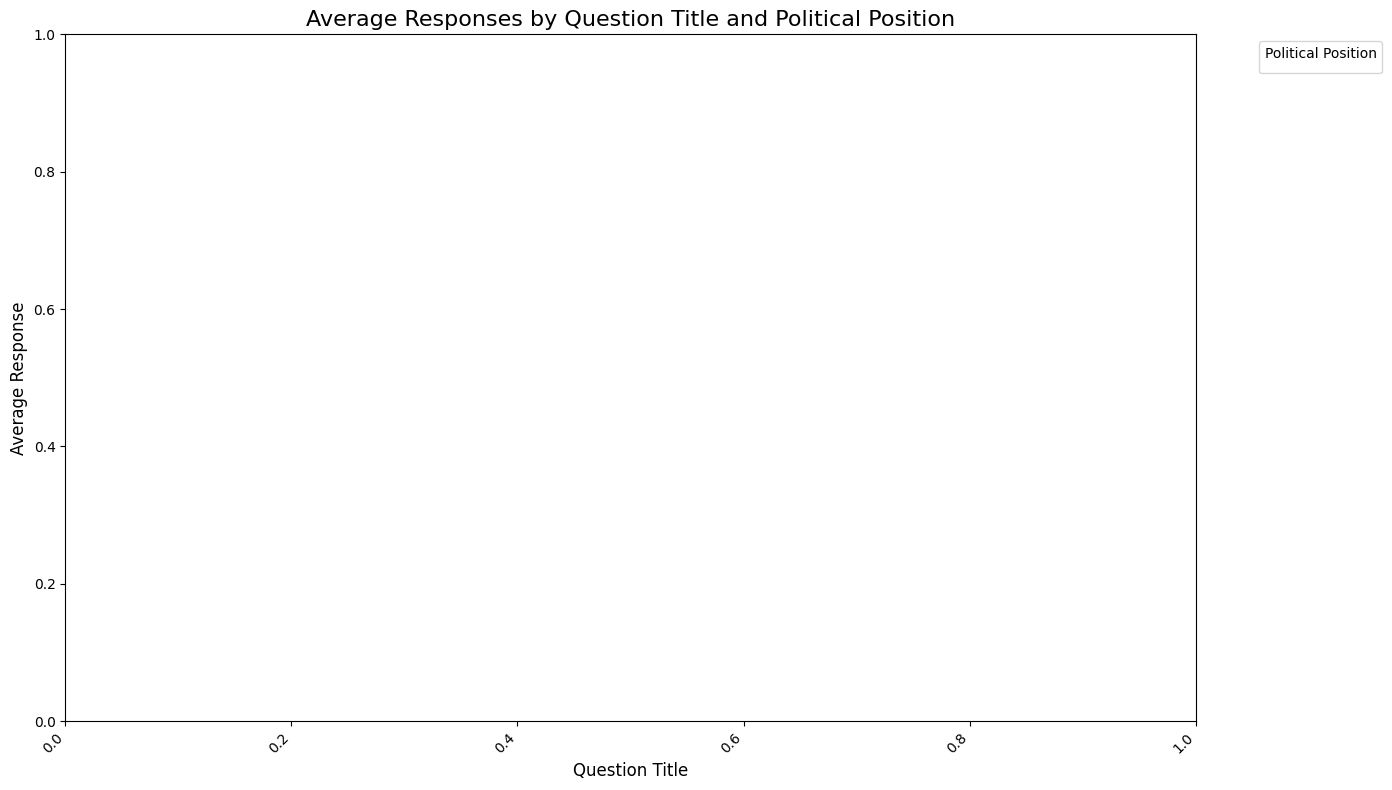

C:\Users\camil\AppData\Local\Temp\ipykernel_32524\3047109946.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  political_Position_df['Political Position'] = pd.Categorical(political_Position_df['Political Position'], categories=position_order, ordered=True)
C:\Users\camil\AppData\Local\Temp\ipykernel_32524\3047109946.py:163: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


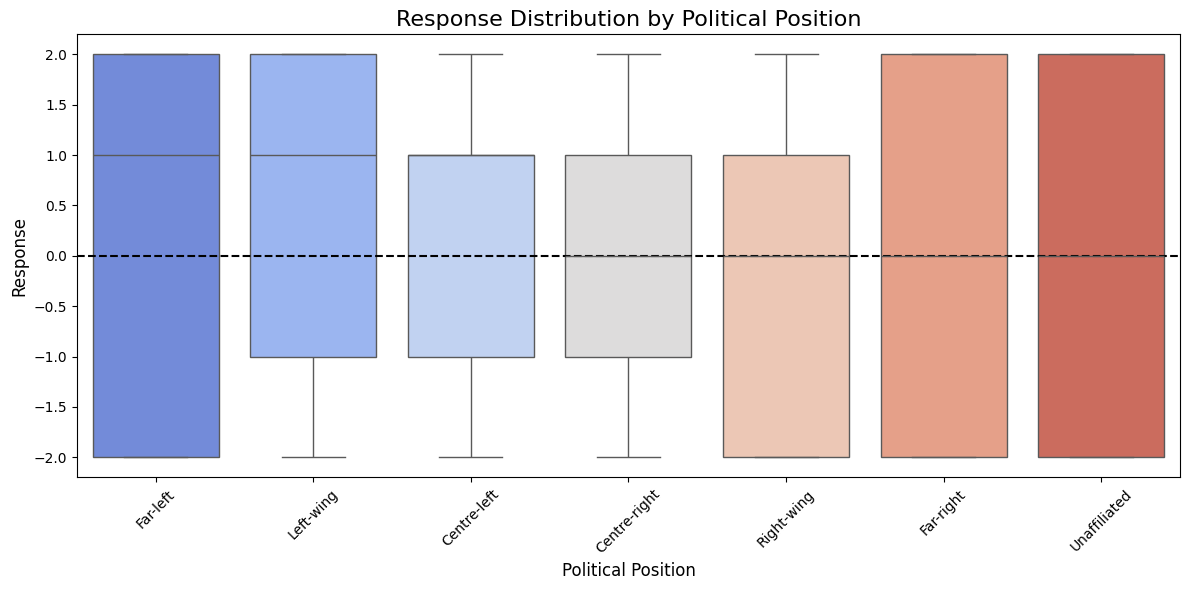

C:\Users\camil\AppData\Local\Temp\ipykernel_32524\3047109946.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


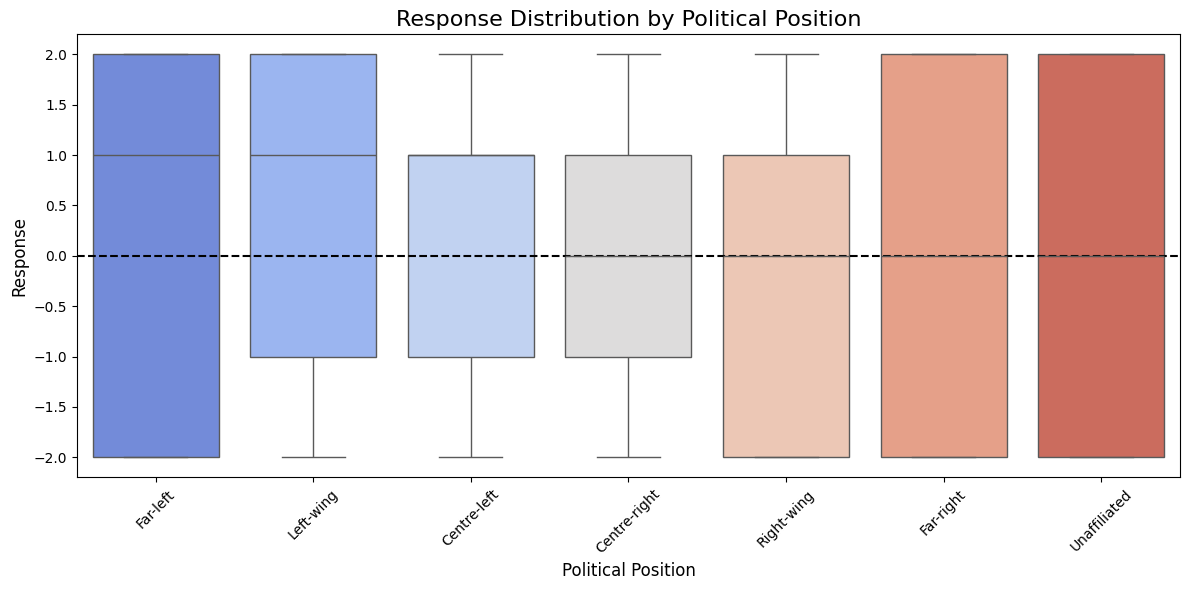

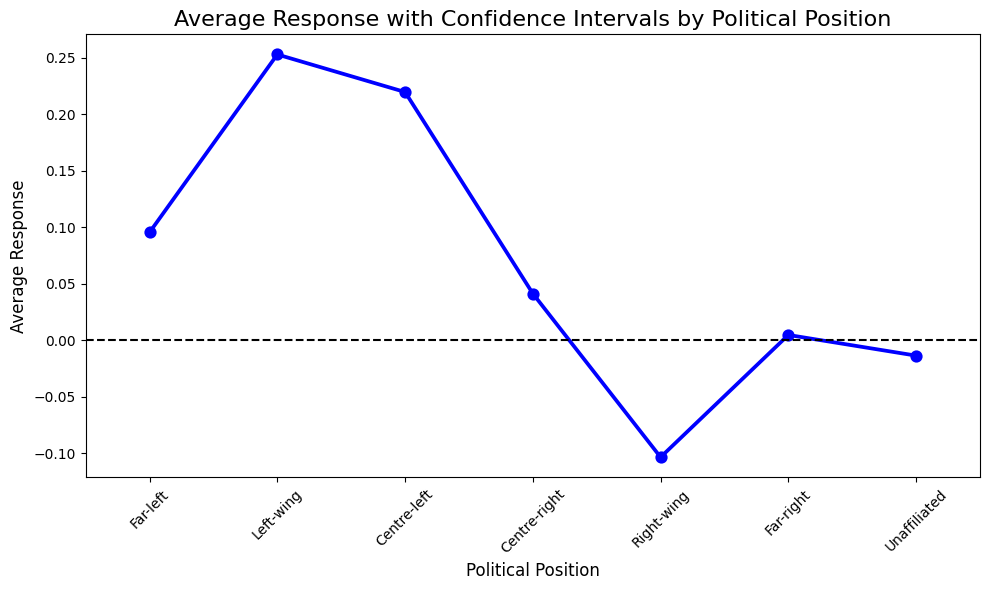

C:\Users\camil\AppData\Local\Temp\ipykernel_32524\3047109946.py:217: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  political_Position_df['strong_opinion'] = np.where(political_Position_df['response'].isin([-2, 2]), 1, 0)


Accuracy: 0.63
              precision    recall  f1-score   support

           0       0.65      0.70      0.68      6964
           1       0.61      0.55      0.58      5781

    accuracy                           0.63     12745
   macro avg       0.63      0.63      0.63     12745
weighted avg       0.63      0.63      0.63     12745

Model Coefficients: [[ 0.16302272 -0.14375075  0.01981606 -0.11793353  0.33841387  1.30579115
  -0.0853739   0.19056663  0.39951586 -0.81156827  0.63084757 -0.53496827
  -0.94451616  0.29715526 -0.94944225 -0.74790375 -0.6877974   0.02201006
   0.65560165 -0.01015059  0.03220506  0.89106172 -0.6735449   0.10284746
   0.56295059 -0.42655126 -0.31783642  0.35468378  0.33841387]]
Intercept: [-0.25827674]


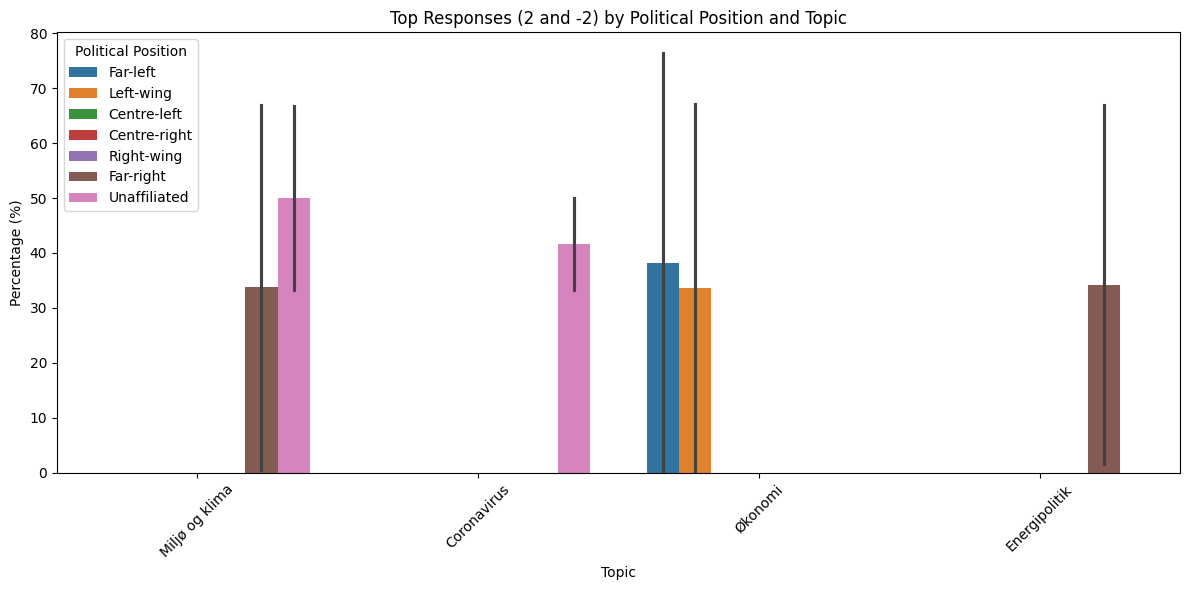

In [162]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
responsesFromBothDRTV2 = pd.read_excel('alldata.xlsx')
responsesFromBothDRTV2.rename(columns={'alder': 'Age', 'storkreds': 'District', 'navn': 'Name', 'parti': 'Party'}, inplace=True)
questionsFromDR=pd.read_excel('drq.xlsx')
questionsFromDR.rename(columns={'ID': 'id', }, inplace=True)
questionsFromTV2=pd.read_excel('tv2q.xlsx')
questionsFromTV2.rename(columns={'question': 'Question', 'header': 'Title'}, inplace=True)


responses_melted = responsesFromBothDRTV2.melt(
    id_vars=['Name', 'Party', 'Age', 'District'],  # Keep candidate information
    value_vars=dr_questions + tv2_questions,  # Use both DR and TV2 question IDs
    var_name='id',  # Create a single 'id' column for both DR and TV2 question IDs
    value_name='response'  # Store responses in 'response' column
)


final_combined_all_candidate_data = pd.merge(
    responses_melted, 
    combined_questions,  # Combine the question text
    on='id',  # Merge on 'id' to match questions with responses
    how='left'  # Use left join to retain all responses
)
# Ensure the 'ID' in DR and 'id' in TV2 question metadata are the same type (string)
questionsFromDR['id'] = questionsFromDR['id'].astype(str)
questionsFromTV2['id'] = questionsFromTV2['id'].astype(str)


# Step 4: Concatenate DR and TV2 question metadata
combined_questions = pd.concat([questionsFromDR[['id', 'Question','Title']], questionsFromTV2[['id', 'Question','Title']]], ignore_index=True)


# Remove the 'Age' and 'District' columns because they are only in the TV2 dataframe
final_combined_all_candidate_data.drop(columns=['Age', 'District'], inplace=True, errors='ignore')

# Step 5: View the final combined data
#print(final_combined_all_candidate_data.head())
#print(final_combined_all_candidate_data.columns.tolist())

# Group by 'Title' and count the responses
response_count_by_title = final_combined_all_candidate_data.groupby('Title')['response'].size().reset_index(name='response_count')
# Sort by 'response_count' in descending order
response_count_by_title_sorted = response_count_by_title.sort_values(by='response_count', ascending=False)


# Display the result
print(response_count_by_title_sorted)

# Create the mapping for parties to political positions
party_to_position = {
    'Moderaterne': 'Centre-left',
    'Socialistisk Folkeparti': 'Left-wing',
    'Alternativet': 'Centre-left',
    'Enhedslisten': 'Far-left',
    'Danmarksdemokraterne': 'Right-wing',
    'Venstre': 'Centre-right',
    'Frie Grønne, Danmarks Nye Venstrefløjsparti': 'Centre-left',
    'Dansk Folkeparti': 'Far-right',
    'Kristendemokraterne': 'Centre-right',
    'Liberal Alliance': 'Right-wing',
    'Nye Borgerlige': 'Far-right',
    'Det Konservative Folkeparti': 'Right-wing',
    'Radikale Venstre': 'Centre-left',
    'Socialdemokratiet': 'Centre-left',
    'Løsgænger' : 'Unaffiliated'
}

# Filter out 'Løsgænger' rows
#filtered_data = final_combined_all_candidate_data[final_combined_all_candidate_data['Party'] != 'Løsgænger']
filtered_data = final_combined_all_candidate_data

# Map the political position to a new column based on the party
filtered_data['Political Position'] = filtered_data['Party'].map(party_to_position)

# Create a new dataframe with only Party, Question, Response, and Political Position columns
political_Position_df = filtered_data[['Party', 'Title','Question', 'response', 'Political Position']]

# View the new dataframe
print(political_Position_df.head())
print(political_Position_df.columns.tolist())

# Step 5: Group by 'Political Position' and calculate average response
average_responses_by_position = political_Position_df.groupby('Political Position')['response'].mean().reset_index()

# Step 6: Define the desired order for the political spectrum
position_order = ['Far-left', 'Left-wing', 'Centre-left', 'Centre-right', 'Right-wing', 'Far-right','Unaffiliated']

# Step 7: Sort the dataframe by the predefined order
average_responses_by_position['Political Position'] = pd.Categorical(
    average_responses_by_position['Political Position'], 
    categories=position_order, 
    ordered=True
)

# Step 8: Sort the dataframe by 'Political Position'
average_responses_by_position = average_responses_by_position.sort_values('Political Position')

# Step 9: Display the result
print(average_responses_by_position)

# Caluclating Most frequent response per political position
most_frequent_responses = (
    political_Position_df.groupby('Political Position')['response']
    .agg(lambda x: pd.Series.mode(x).loc[0])  # Get the most frequent response (mode)
    .reset_index()  # Reset index to get a proper DataFrame
)
print(most_frequent_responses)




# Step 1: Count the number of responses and calculate average responses by Title and Political Position
response_counts = (political_Position_df
                   .groupby(['Title', 'Political Position'])
                   .agg(response_count=('response', 'size'),
                        average_response=('response', 'mean'))  # Calculate average response too
                   .reset_index())

# Step 2: Filter for the specific titles you want
titles_to_include = ['ARBEJDSMARKED OG ØKONOMI', 'VELFÆRD', 'EU OG UDENRIGS', 'KLIMA OG ENERGI']
filtered_response_counts = response_counts[response_counts['Title'].isin(titles_to_include)]

# Step 3: Create a bubble plot
plt.figure(figsize=(14, 8))
sns.scatterplot(
    x='Title',  # X-axis for question titles
    y='average_response',  # Y-axis for average response values
    size='response_count',  # Size of the bubbles based on response count
    sizes=(100, 2000),  # Adjust size range for bubbles
    hue='Political Position',  # Color bubbles based on political positions
    palette='deep',  # Color palette for political positions
    data=filtered_response_counts,
    alpha=0.6,  # Transparency
    edgecolor='black'  # Optional: add black edge around the bubbles
)

# Step 4: Customize the plot
plt.title('Average Responses by Question Title and Political Position', fontsize=16)
plt.xlabel('Question Title', fontsize=12)
plt.ylabel('Average Response', fontsize=12)

# Step 5: Rotate x-tick labels for better readability
plt.xticks(rotation=45, ha='right')

# Step 6: Show the legend
plt.legend(title='Political Position', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside

# Step 7: Show the plot
plt.tight_layout()
plt.show()
# Convert the 'Political Position' column to a categorical type with the specified order
political_Position_df['Political Position'] = pd.Categorical(political_Position_df['Political Position'], categories=position_order, ordered=True)
# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='Political Position',
    y='response',
    data=political_Position_df,
    palette='coolwarm'
)

plt.title('Response Distribution by Political Position', fontsize=16)
plt.xlabel('Political Position', fontsize=12)
plt.ylabel('Response', fontsize=12)
plt.axhline(0, color='black', linestyle='--')  # Add a horizontal line at 0 for reference
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(
    x='Political Position',
    y='response',
    data=political_Position_df,
    palette='coolwarm'
)

plt.title('Response Distribution by Political Position', fontsize=16)
plt.xlabel('Political Position', fontsize=12)
plt.ylabel('Response', fontsize=12)
plt.axhline(0, color='black', linestyle='--')  # Add a horizontal line at 0 for reference
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 6))
sns.pointplot(
    x='Political Position',
    y='response',
    data=average_responses_by_position.reset_index(),
    capsize=0.1,
    color='blue'
)

plt.title('Average Response with Confidence Intervals by Political Position', fontsize=16)
plt.xlabel('Political Position', fontsize=12)
plt.ylabel('Average Response', fontsize=12)
plt.axhline(0, color='black', linestyle='--')  # Add a horizontal line at 0 for reference

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



# Step 1: Create the binary outcome for strong opinions (either -2 or 2)
political_Position_df['strong_opinion'] = np.where(political_Position_df['response'].isin([-2, 2]), 1, 0)

# Step 2: Create a binary predictor for far-left political position
political_Position_df['is_far_left'] = np.where(political_Position_df['Political Position'] == 'Far-left', 1, 0)

# Step 3: Prepare the final dataset with relevant columns
# Include more features like 'Party' and 'Title'
data_for_model = political_Position_df[['is_far_left', 'strong_opinion', 'Party', 'Title']]

# Step 4: Create a binary target variable for strong opinions
# 1 if strong opinion (either -2 or 2), 0 otherwise
y = data_for_model['strong_opinion']

# Step 5: Prepare features
# One-Hot Encode categorical features 'Party' and 'Title'
X = data_for_model[['is_far_left', 'Party', 'Title']]

# Step 6: Preprocessing with OneHotEncoder
# Create a pipeline to handle encoding and model fitting
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['Party', 'Title']),
        ('num', 'passthrough', ['is_far_left'])  # Keep the binary feature as is
    ]
)

# Step 7: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 8: Initialize and fit the logistic regression model
model = Pipeline(steps=[('preprocessor', preprocessor),
                         ('logistic', LogisticRegression())])

model.fit(X_train, y_train)

# Step 9: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 10: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

# Optionally, check the model coefficients (Note: Coefficients are not directly interpretable after OneHotEncoding)
# However, you can inspect the model's attributes
print(f"Model Coefficients: {model.named_steps['logistic'].coef_}")
print(f"Intercept: {model.named_steps['logistic'].intercept_}")

# Filter for responses that are either 2 or -2


filtered_responses = political_Position_df[political_Position_df['response'].isin([2, -2])]

# Group by political position, title, and response, then count occurrences
count_responses = filtered_responses.groupby(['Political Position', 'Title', 'response']).size().reset_index(name='Count')

# Step 1: Calculate total responses (including all response values, not just 2 and -2)
total_responses = political_Position_df.groupby(['Political Position', 'Title']).size().reset_index(name='Total_Responses')

# Step 2: Merge total responses with the filtered count_responses DataFrame
merged_df = count_responses.merge(total_responses, on=['Political Position', 'Title'])

# Step 3: Calculate the percentage for responses of 2 and -2
merged_df['Percentage'] = (merged_df['Count'] / merged_df['Total_Responses']) * 100

# Step 4: Pivot the table so that you have separate columns for the % of 2 and % of -2
final_df = merged_df.pivot_table(index=['Political Position', 'Title'], 
                                 columns='response', 
                                 values='Percentage').reset_index()

# Rename columns for better readability
final_df.columns = ['Political Position', 'Title', '% of -2', '% of 2',]

# Sort the final DataFrame by '% of -2' in descending order
final_df_sorted = final_df.sort_values(by='% of -2', ascending=False)

# Get the top 3 for % of -2
top_3_negative = final_df_sorted.nlargest(3, '% of -2')

# Get the top 3 for % of 2
top_3_positive = final_df_sorted.nlargest(3, '% of 2')

# Combine the top 3 DataFrames
top_titles = pd.concat([top_3_negative, top_3_positive]).drop_duplicates()

# Melt the DataFrame to have a long format for seaborn, including Political Position
melted_df = top_titles.melt(id_vars=['Political Position', 'Title'], 
                              value_vars=['% of 2', '% of -2'], 
                              var_name='Response Type', 
                              value_name='Percentage')

# Create the plot
plt.figure(figsize=(12, 6))

# Change hue to 'Political Position' for better distinction
sns.barplot(data=melted_df, x='Title', y='Percentage', hue='Political Position', dodge=True)

# Add labels and title
plt.title('Top Responses (2 and -2) by Political Position and Topic')
plt.xlabel('Topic')
plt.ylabel('Percentage (%)')
plt.legend(title='Political Position')  # Change legend title to Political Position
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()
# Assuming 'top_titles' DataFrame is available and has '% of -2' and '% of 2'
# Replace NaN values with 0 in '% of -2' and '% of 2' columns
top_titles['% of -2'] = top_titles['% of -2'].fillna(0)
top_titles['% of 2'] = top_titles['% of 2'].fillna(0)






In [ ]:
# Replace NaN values with 0 in '% of -2' and '% of 2' columns
top_titles['% of -2'] = top_titles['% of -2'].fillna(0)
top_titles['% of 2'] = top_titles['% of 2'].fillna(0)

# Step 1: Merge political_Position_df with top_titles
# Assuming 'Title' and 'Political Position' are the keys to merge
combined_df = pd.merge(
    political_Position_df,
    top_titles[['Title', 'Political Position', '% of -2', '% of 2']],
    on=['Title', 'Political Position'],  # Merge on Title and Political Position
    how='left'  # Use a left join to keep all rows from political_Position_df
)

# Step 2: Select relevant columns for the new DataFrame
data_for_model = combined_df[['Party', 'Political Position', 'Title', 'Question', 'response', '% of -2', '% of 2']]

# Optional: View the new DataFrame
print(data_for_model.head())
print(data_for_model.columns.tolist())


In [158]:
#

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
responsesFromBothDRTV2 = pd.read_excel('alldata.xlsx')
responsesFromBothDRTV2.rename(columns={'alder': 'Age', 'storkreds': 'District', 'navn': 'Name', 'parti': 'Party'}, inplace=True)
questionsFromDR=pd.read_excel('drq.xlsx')
questionsFromDR.rename(columns={'ID': 'id', }, inplace=True)
questionsFromTV2=pd.read_excel('tv2q.xlsx')
questionsFromTV2.rename(columns={'question': 'Question', 'header': 'Title'}, inplace=True)


responses_melted = responsesFromBothDRTV2.melt(
    id_vars=['Name', 'Party', 'Age', 'District'],  # Keep candidate information
    value_vars=dr_questions + tv2_questions,  # Use both DR and TV2 question IDs
    var_name='id',  # Create a single 'id' column for both DR and TV2 question IDs
    value_name='response'  # Store responses in 'response' column
)

final_combined_all_candidate_data = pd.merge(
    responses_melted, 
    combined_questions,  # Combine the question text
    on='id',  # Merge on 'id' to match questions with responses
    how='left'  # Use left join to retain all responses
)
# Ensure the 'ID' in DR and 'id' in TV2 question metadata are the same type (string)
questionsFromDR['id'] = questionsFromDR['id'].astype(str)
questionsFromTV2['id'] = questionsFromTV2['id'].astype(str)


# Step 4: Concatenate DR and TV2 question metadata
combined_questions = pd.concat([questionsFromDR[['id', 'Question','Title']], questionsFromTV2[['id', 'Question','Title']]], ignore_index=True)


# Remove the 'Age' and 'District' columns because they are only in the TV2 dataframe
final_combined_all_candidate_data.drop(columns=['Age', 'District'], inplace=True, errors='ignore')

# Create the mapping for parties to political positions
party_to_position = {
    'Moderaterne': 'Centre-left',
    'Socialistisk Folkeparti': 'Left-wing',
    'Alternativet': 'Centre-left',
    'Enhedslisten': 'Far-left',
    'Danmarksdemokraterne': 'Right-wing',
    'Venstre': 'Centre-right',
    'Frie Grønne, Danmarks Nye Venstrefløjsparti': 'Centre-left',
    'Dansk Folkeparti': 'Far-right',
    'Kristendemokraterne': 'Centre-right',
    'Liberal Alliance': 'Right-wing',
    'Nye Borgerlige': 'Far-right',
    'Det Konservative Folkeparti': 'Right-wing',
    'Radikale Venstre': 'Centre-left',
    'Socialdemokratiet': 'Centre-left',
    'Løsgænger': 'Unaffiliated'
}
#Channel had no effect on the data model
station_mapping = {
    '530': 'DR', '531': 'DR', '533': 'DR', '534': 'DR', '535': 'DR', '537': 'DR',
    '538': 'DR', '540': 'DR', '541': 'DR', '543': 'DR', '544': 'DR', '545': 'DR',
    '546': 'DR', '547': 'DR', '548': 'DR', '550': 'DR', '551': 'DR', '552': 'DR',
    '553': 'DR', '555': 'DR', '556': 'DR', '557': 'DR', '559': 'DR', '561': 'DR',
    '563': 'DR',
    '1a': 'TV2', '1b': 'TV2', '2a': 'TV2', '2b': 'TV2', '3a': 'TV2', '3b': 'TV2',
    '4a': 'TV2', '4b': 'TV2', '5a': 'TV2', '5b': 'TV2', '6a': 'TV2', '6b': 'TV2',
    '7a': 'TV2', '7b': 'TV2', '8a': 'TV2', '8b': 'TV2', '9a': 'TV2', '9b': 'TV2',
    '10a': 'TV2', '10b': 'TV2', '11a': 'TV2', '11b': 'TV2', '12a': 'TV2', '12b': 'TV2'
}


# Filter out 'Løsgænger' rows
#filtered_data = final_combined_all_candidate_data[final_combined_all_candidate_data['Party'] != 'Løsgænger']

# Map the political position to a new column based on the party
filtered_data['Political Position'] = filtered_data['Party'].map(party_to_position)

filtered_data['Channel'] = filtered_data['id'].map(station_mapping)

# Create a new dataframe with only Party, Question, Response, and Political Position columns
political_Position_df = filtered_data[['Party', 'Title','Question', 'response', 'Political Position','Channel']]

# Step 1: Create the binary outcome for strong opinions (either -2 or 2)
political_Position_df['strong_opinion'] = np.where(political_Position_df['response'].isin([-2, 2]), 1, 0)

# Step 2: Create a binary predictor for far-left political position
political_Position_df['is_far_left'] = np.where(political_Position_df['Political Position'] == 'Far-left', 1, 0)

# Step 3: Prepare the final dataset with relevant columns
# Include more features like 'Party' and 'Title'
data_for_model = political_Position_df[['is_far_left', 'strong_opinion', 'Party', 'Title','Channel']]

# Step 4: Create a binary target variable for strong opinions
# 1 if strong opinion (either -2 or 2), 0 otherwise
y = data_for_model['strong_opinion']

# Step 5: Prepare features
# One-Hot Encode categorical features 'Party' and 'Title'
X = data_for_model[['is_far_left', 'Party', 'Title','Channel']]

# Step 6: Preprocessing with OneHotEncoder
# Create a pipeline to handle encoding and model fitting
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['Party', 'Title','Channel']),
        ('num', 'passthrough', ['is_far_left'])  # Keep the binary feature as is
    ]
)

# Step 7: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 8: Initialize and fit the logistic regression model
model = Pipeline(steps=[('preprocessor', preprocessor),
                         ('logistic', LogisticRegression())])

model.fit(X_train, y_train)

# Step 9: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 10: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

# Optionally, check the model coefficients (Note: Coefficients are not directly interpretable after OneHotEncoding)
# However, you can inspect the model's attributes
print(f"Model Coefficients: {model.named_steps['logistic'].coef_}")
print(f"Intercept: {model.named_steps['logistic'].intercept_}")










Accuracy: 0.66
              precision    recall  f1-score   support

           0       0.70      0.83      0.76      3858
           1       0.56      0.39      0.46      2243

    accuracy                           0.66      6101
   macro avg       0.63      0.61      0.61      6101
weighted avg       0.65      0.66      0.65      6101

Model Coefficients: [[ 0.37072994  1.52711874  0.15938911 -0.47541046 -0.30981301 -0.71265999
  -0.78147667 -0.29144705 -0.79602858  0.19363712  1.02022712  0.270884
   0.03131684  0.87309243 -0.4386864  -0.13802845  0.0769372  -0.55511856
  -0.50380476  0.03489675  0.03489675 -0.25701909  0.        ]]
Intercept: [-0.22883777]


C:\Users\camil\AppData\Local\Temp\ipykernel_32524\3192930258.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  political_Position_df['strong_opinion'] = np.where(political_Position_df['response'].isin([-2, 2]), 1, 0)
C:\Users\camil\AppData\Local\Temp\ipykernel_32524\3192930258.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  political_Position_df['is_far_left'] = np.where(political_Position_df['Political Position'] == 'Far-left', 1, 0)


Naibe Bayes Theorem: (Predicts conditional probabiltiy- likelihood of x given y)

The goal of this analysis was to predict whether individuals from parties within the Centre-left and Centre-right political position exhibit strong opinions, characterized by responses of either -2 or 2. These political affiliations contain the highest number of parties. Data was collected from alldata.xlsx, which includes responses from both DR and TV2, along with metadata from corresponding question files. The dataset was then reshaped using the melt function to consolidate responses, and necessary columns were renamed for clarity. This facilitated easier analysis of candidate responses. A mapping was created to classify parties into political positions (e.g., Centre-left, Centre-right, etc.). This classification enabled the creation of binary predictors for Centre-left and Centre-right affiliations. A binary outcome variable strong_opinion was created, coding responses of -2 or 2 as 1 (strong opinion) and all other responses as 0 (no strong opinion). A Multinomial Naive Bayes model was implemented using a pipeline that included preprocessing steps with OneHotEncoder for categorical variables. The data was split into training (70%) and testing (30%) sets. 

In [157]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

responsesFromBothDRTV2 = pd.read_excel('alldata.xlsx')
responsesFromBothDRTV2.rename(columns={'alder': 'Age', 'storkreds': 'District', 'navn': 'Name', 'parti': 'Party'}, inplace=True)
questionsFromDR=pd.read_excel('drq.xlsx')
questionsFromDR.rename(columns={'ID': 'id', }, inplace=True)
questionsFromTV2=pd.read_excel('tv2q.xlsx')
questionsFromTV2.rename(columns={'question': 'Question', 'header': 'Title'}, inplace=True)


responses_melted = responsesFromBothDRTV2.melt(
    id_vars=['Name', 'Party', 'Age', 'District'],  # Keep candidate information
    value_vars=dr_questions + tv2_questions,  # Use both DR and TV2 question IDs
    var_name='id',  # Create a single 'id' column for both DR and TV2 question IDs
    value_name='response'  # Store responses in 'response' column
)

final_combined_all_candidate_data = pd.merge(
    responses_melted, 
    combined_questions,  # Combine the question text
    on='id',  # Merge on 'id' to match questions with responses
    how='left'  # Use left join to retain all responses
)
# Ensure the 'ID' in DR and 'id' in TV2 question metadata are the same type (string)
questionsFromDR['id'] = questionsFromDR['id'].astype(str)
questionsFromTV2['id'] = questionsFromTV2['id'].astype(str)


# Step 4: Concatenate DR and TV2 question metadata
combined_questions = pd.concat([questionsFromDR[['id', 'Question','Title']], questionsFromTV2[['id', 'Question','Title']]], ignore_index=True)


# Remove the 'Age' and 'District' columns because they are only in the TV2 dataframe
final_combined_all_candidate_data.drop(columns=['Age', 'District'], inplace=True, errors='ignore')

# Create the mapping for parties to political positions
party_to_position = {
    'Moderaterne': 'Centre-left',
    'Socialistisk Folkeparti': 'Left-wing',
    'Alternativet': 'Centre-left',
    'Enhedslisten': 'Far-left',
    'Danmarksdemokraterne': 'Right-wing',
    'Venstre': 'Centre-right',
    'Frie Grønne, Danmarks Nye Venstrefløjsparti': 'Centre-left',
    'Dansk Folkeparti': 'Far-right',
    'Kristendemokraterne': 'Centre-right',
    'Liberal Alliance': 'Right-wing',
    'Nye Borgerlige': 'Far-right',
    'Det Konservative Folkeparti': 'Right-wing',
    'Radikale Venstre': 'Centre-left',
    'Socialdemokratiet': 'Centre-left',
    'Løsgænger': 'Unaffiliated'
}
#Channel had no effect on the data model
station_mapping = {
    '530': 'DR', '531': 'DR', '533': 'DR', '534': 'DR', '535': 'DR', '537': 'DR',
    '538': 'DR', '540': 'DR', '541': 'DR', '543': 'DR', '544': 'DR', '545': 'DR',
    '546': 'DR', '547': 'DR', '548': 'DR', '550': 'DR', '551': 'DR', '552': 'DR',
    '553': 'DR', '555': 'DR', '556': 'DR', '557': 'DR', '559': 'DR', '561': 'DR',
    '563': 'DR',
    '1a': 'TV2', '1b': 'TV2', '2a': 'TV2', '2b': 'TV2', '3a': 'TV2', '3b': 'TV2',
    '4a': 'TV2', '4b': 'TV2', '5a': 'TV2', '5b': 'TV2', '6a': 'TV2', '6b': 'TV2',
    '7a': 'TV2', '7b': 'TV2', '8a': 'TV2', '8b': 'TV2', '9a': 'TV2', '9b': 'TV2',
    '10a': 'TV2', '10b': 'TV2', '11a': 'TV2', '11b': 'TV2', '12a': 'TV2', '12b': 'TV2'
}

# Map the political position to a new column based on the party
filtered_data['Political Position'] = filtered_data['Party'].map(party_to_position)

filtered_data['Channel'] = filtered_data['id'].map(station_mapping)

# Create a new dataframe with only Party, Question, Response, and Political Position columns
political_Position_df = filtered_data[['Party', 'Title','Question', 'response', 'Political Position','Channel']]
political_Position_df_cleaned = political_Position_df.dropna(subset=['Question', 'Title'])


# Step 1: Create the binary outcome for strong opinions (either -2 or 2)
political_Position_df_cleaned['strong_opinion'] = np.where(political_Position_df_cleaned['response'].isin([-2, 2]), 1, 0)

# Step 2: Create binary predictors for centre-left, centre-right, and non-centre-left-or-centre-right positions
# Keep the existing predictors for Centre-left and Centre-right
political_Position_df_cleaned['is_centre_left'] = np.where(political_Position_df_cleaned['Political Position'] == 'Centre-left', 1, 0)
political_Position_df_cleaned['is_centre_right'] = np.where(political_Position_df_cleaned['Political Position'] == 'Centre-right', 1, 0)

# New binary predictor for parties that are neither Centre-left nor Centre-right
political_Position_df_cleaned['is_not_centre_left_or_centre_right'] = np.where(
    (political_Position_df_cleaned['Political Position'] != 'Centre-left') & 
    (political_Position_df_cleaned['Political Position'] != 'Centre-right'), 1, 0)

# Step 3: Prepare the final dataset with relevant columns
# Include more features like 'Party', 'Title', 'Channel', and the binary predictors
data_for_model = political_Position_df_cleaned[['is_not_centre_left_or_centre_right', 'strong_opinion', 'Party', 'Title']]

# Step 4: Create a binary target variable for strong opinions
# 1 if strong opinion (either -2 or 2), 0 otherwise
y = data_for_model['strong_opinion']

# Step 5: Prepare features
# Include 'is_not_centre_left_or_centre_right', 'Party', 'Title', and 'Channel'
X = data_for_model[['is_not_centre_left_or_centre_right', 'Party', 'Title']]

# Step 6: Preprocessing with OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['Party', 'Title']),  # One-Hot Encode categorical features
        ('num', 'passthrough', ['is_not_centre_left_or_centre_right'])  # Pass through the new binary feature
    ]
)


# Step 7: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 8: Initialize and fit the Naive Bayes model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('naive_bayes', MultinomialNB())])

model.fit(X_train, y_train)

# Step 9: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 10: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred)) 

Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.68      0.93      0.79      1936
           1       0.63      0.20      0.31      1052

    accuracy                           0.68      2988
   macro avg       0.66      0.57      0.55      2988
weighted avg       0.66      0.68      0.62      2988



C:\Users\camil\AppData\Local\Temp\ipykernel_32524\3779617398.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  political_Position_df_cleaned['strong_opinion'] = np.where(political_Position_df_cleaned['response'].isin([-2, 2]), 1, 0)
C:\Users\camil\AppData\Local\Temp\ipykernel_32524\3779617398.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  political_Position_df_cleaned['is_centre_left'] = np.where(political_Position_df_cleaned['Political Position'] == 'Centre-left', 1, 0)
C:\Users\camil\AppData\Loca

The model's performance was evaluated using accuracy, precision, recall, and F1-score metrics. The model achieved an accuracy of 68%. This means that approximately two-thirds of the predictions made by the model were correct. Unfortunately, despite this, the model had a high This analysis provides insight into the relationship between political affiliation and the likelihood of expressing strong opinions. Despite achieving reasonable accuracy, the model's precision and recall metrics indicate that there is significant potential for improvement. 